In [1]:
import glob
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
import natsort

In [2]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures

# rf
from sklearn.ensemble import RandomForestClassifier

In [3]:
seed = 0
tf.random.set_seed(seed)

model_metrics = 'acc'    # acc, mse, mae (epoch마다 표시)
num_epochs = 10
num_batch = 100
num_split = 0.2

In [4]:
#새로운 feature 추가 데이터
new_H_path= 'D:/sensors journal/TT_H/train/existing/txt'
new_H_files = glob.glob(os.path.join(new_H_path, "*.txt"))
new_H_files = natsort.natsorted(new_H_files)
print(new_H_files)
new_H_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in new_H_files)

['D:/sensors journal/TT_H/train/existing/txt\\1.txt', 'D:/sensors journal/TT_H/train/existing/txt\\2.txt', 'D:/sensors journal/TT_H/train/existing/txt\\3.txt', 'D:/sensors journal/TT_H/train/existing/txt\\4.txt', 'D:/sensors journal/TT_H/train/existing/txt\\5.txt', 'D:/sensors journal/TT_H/train/existing/txt\\6.txt', 'D:/sensors journal/TT_H/train/existing/txt\\7.txt', 'D:/sensors journal/TT_H/train/existing/txt\\8.txt', 'D:/sensors journal/TT_H/train/existing/txt\\9.txt', 'D:/sensors journal/TT_H/train/existing/txt\\10.txt', 'D:/sensors journal/TT_H/train/existing/txt\\11.txt', 'D:/sensors journal/TT_H/train/existing/txt\\12.txt', 'D:/sensors journal/TT_H/train/existing/txt\\13.txt', 'D:/sensors journal/TT_H/train/existing/txt\\14.txt', 'D:/sensors journal/TT_H/train/existing/txt\\15.txt', 'D:/sensors journal/TT_H/train/existing/txt\\16.txt', 'D:/sensors journal/TT_H/train/existing/txt\\17.txt', 'D:/sensors journal/TT_H/train/existing/txt\\18.txt', 'D:/sensors journal/TT_H/train/exist

In [5]:
#test 데이터
test_H_path= 'D:/sensors journal/TT_H/test/existing/txt'
test_H_files = glob.glob(os.path.join(test_H_path, "*.txt"))
test_H_files = natsort.natsorted(test_H_files)
print(test_H_files)
test_H_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in test_H_files)

['D:/sensors journal/TT_H/test/existing/txt\\1.txt', 'D:/sensors journal/TT_H/test/existing/txt\\2.txt', 'D:/sensors journal/TT_H/test/existing/txt\\3.txt', 'D:/sensors journal/TT_H/test/existing/txt\\4.txt', 'D:/sensors journal/TT_H/test/existing/txt\\5.txt', 'D:/sensors journal/TT_H/test/existing/txt\\6.txt', 'D:/sensors journal/TT_H/test/existing/txt\\7.txt', 'D:/sensors journal/TT_H/test/existing/txt\\8.txt', 'D:/sensors journal/TT_H/test/existing/txt\\9.txt', 'D:/sensors journal/TT_H/test/existing/txt\\10.txt', 'D:/sensors journal/TT_H/test/existing/txt\\11.txt', 'D:/sensors journal/TT_H/test/existing/txt\\12.txt', 'D:/sensors journal/TT_H/test/existing/txt\\13.txt', 'D:/sensors journal/TT_H/test/existing/txt\\14.txt', 'D:/sensors journal/TT_H/test/existing/txt\\15.txt', 'D:/sensors journal/TT_H/test/existing/txt\\16.txt', 'D:/sensors journal/TT_H/test/existing/txt\\17.txt', 'D:/sensors journal/TT_H/test/existing/txt\\18.txt', 'D:/sensors journal/TT_H/test/existing/txt\\19.txt', '

In [6]:
#class별 비율 확인 - feature 추가된 파일
new_H_file_list = list(new_H_each_file)
print(new_H_file_list)
new_input_num=12
ratio = 2
new_sampling_ratio_H = []

for i in new_H_file_list:
    class0 = len(i[i[new_input_num]==0]) 
    class1 = len(i[i[new_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("new_sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    new_sampling_ratio_H.append(ratio*class1/class0)

[        0    1   2       3    4       5    6    7       8       9       10  \
0     0.50  1.0   1  0.3333  0.5  1.0000  0.0  1.0  0.3333  0.0000  0.3175   
1     0.50  0.5   0  0.5000  1.0  0.0606  1.0  1.0  0.3333  0.0000  0.3175   
2     0.50  1.0   0  0.3333  1.0  1.0000  1.0  1.0  0.3333  0.3333  0.3175   
3     0.50  0.5   0  0.8000  1.0  0.0606  0.5  1.0  0.3333  0.0000  0.3175   
4     0.75  1.0   0  0.3333  0.5  0.9848  1.0  1.0  0.3333  0.0000  0.3175   
...    ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
5296  0.50  0.0   1  0.5000  1.0  0.7273  1.0  1.0  0.3333  0.0000  0.6349   
5297  0.50  0.0   1  0.6667  0.5  0.7576  1.0  1.0  0.3333  0.0000  0.6349   
5298  0.50  0.5   1  0.6667  0.5  0.7424  1.0  1.0  0.3333  0.0000  0.6349   
5299  0.50  0.0   0  0.5000  1.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   
5300  0.50  1.0   0  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   

      11  12  
0      1   0  
1      1   0  
2      1   0  
3 

new_sampling ratio:  0.30 

class0:  7426
class1:  731
class0/class1:  10.16
new_sampling ratio:  0.20 

class0:  3952
class1:  505
class0/class1:  7.83
new_sampling ratio:  0.26 

class0:  20000
class1:  3480
class0/class1:  5.75
new_sampling ratio:  0.35 

class0:  2373
class1:  345
class0/class1:  6.88
new_sampling ratio:  0.29 

class0:  49656
class1:  5343
class0/class1:  9.29
new_sampling ratio:  0.22 

class0:  20661
class1:  2890
class0/class1:  7.15
new_sampling ratio:  0.28 

class0:  6510
class1:  1128
class0/class1:  5.77
new_sampling ratio:  0.35 

class0:  18167
class1:  2081
class0/class1:  8.73
new_sampling ratio:  0.23 

class0:  28704
class1:  2942
class0/class1:  9.76
new_sampling ratio:  0.20 

class0:  26433
class1:  2501
class0/class1:  10.57
new_sampling ratio:  0.19 

class0:  14885
class1:  2595
class0/class1:  5.74
new_sampling ratio:  0.35 

class0:  4084
class1:  480
class0/class1:  8.51
new_sampling ratio:  0.24 

class0:  2446
class1:  232
class0/class1:  

class0:  48031
class1:  2440
class0/class1:  19.68
new_sampling ratio:  0.10 

class0:  905
class1:  123
class0/class1:  7.36
new_sampling ratio:  0.27 

class0:  1299
class1:  176
class0/class1:  7.38
new_sampling ratio:  0.27 

class0:  8155
class1:  887
class0/class1:  9.19
new_sampling ratio:  0.22 

class0:  30102
class1:  2837
class0/class1:  10.61
new_sampling ratio:  0.19 

class0:  12489
class1:  1479
class0/class1:  8.44
new_sampling ratio:  0.24 

class0:  8497
class1:  397
class0/class1:  21.40
new_sampling ratio:  0.09 

class0:  6588
class1:  694
class0/class1:  9.49
new_sampling ratio:  0.21 

class0:  21418
class1:  2730
class0/class1:  7.85
new_sampling ratio:  0.25 

class0:  9758
class1:  1780
class0/class1:  5.48
new_sampling ratio:  0.36 

class0:  35929
class1:  6006
class0/class1:  5.98
new_sampling ratio:  0.33 

class0:  17178
class1:  1526
class0/class1:  11.26
new_sampling ratio:  0.18 

class0:  1966
class1:  246
class0/class1:  7.99
new_sampling ratio:  0.2

class0:  34691
class1:  5540
class0/class1:  6.26
new_sampling ratio:  0.32 

class0:  24664
class1:  4594
class0/class1:  5.37
new_sampling ratio:  0.37 

class0:  3767
class1:  764
class0/class1:  4.93
new_sampling ratio:  0.41 

class0:  415
class1:  50
class0/class1:  8.30
new_sampling ratio:  0.24 

class0:  2939
class1:  734
class0/class1:  4.00
new_sampling ratio:  0.50 

class0:  3168
class1:  910
class0/class1:  3.48
new_sampling ratio:  0.57 

class0:  40365
class1:  7136
class0/class1:  5.66
new_sampling ratio:  0.35 

class0:  3411
class1:  152
class0/class1:  22.44
new_sampling ratio:  0.09 

class0:  28647
class1:  2266
class0/class1:  12.64
new_sampling ratio:  0.16 

class0:  39178
class1:  3962
class0/class1:  9.89
new_sampling ratio:  0.20 

class0:  14547
class1:  681
class0/class1:  21.36
new_sampling ratio:  0.09 

class0:  16662
class1:  2693
class0/class1:  6.19
new_sampling ratio:  0.32 

class0:  11618
class1:  1513
class0/class1:  7.68
new_sampling ratio:  0.2

class0:  13808
class1:  2136
class0/class1:  6.46
new_sampling ratio:  0.31 

class0:  17366
class1:  2928
class0/class1:  5.93
new_sampling ratio:  0.34 

class0:  11659
class1:  1988
class0/class1:  5.86
new_sampling ratio:  0.34 

class0:  3340
class1:  329
class0/class1:  10.15
new_sampling ratio:  0.20 

class0:  2111
class1:  252
class0/class1:  8.38
new_sampling ratio:  0.24 

class0:  4471
class1:  432
class0/class1:  10.35
new_sampling ratio:  0.19 

class0:  2545
class1:  281
class0/class1:  9.06
new_sampling ratio:  0.22 

class0:  3789
class1:  579
class0/class1:  6.54
new_sampling ratio:  0.31 

class0:  7136
class1:  1006
class0/class1:  7.09
new_sampling ratio:  0.28 

class0:  1887
class1:  267
class0/class1:  7.07
new_sampling ratio:  0.28 

class0:  14596
class1:  2305
class0/class1:  6.33
new_sampling ratio:  0.32 

class0:  16080
class1:  2784
class0/class1:  5.78
new_sampling ratio:  0.35 

class0:  10719
class1:  1754
class0/class1:  6.11
new_sampling ratio:  0.33

In [7]:
#class별 비율 확인 - feature 추가된 파일
test_H_file_list = list(test_H_each_file)
print(test_H_file_list)
new_input_num=12
ratio = 2
test_sampling_ratio_H = []

for i in test_H_file_list:
    class0 = len(i[i[new_input_num]==0]) 
    class1 = len(i[i[new_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("new_sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    test_sampling_ratio_H.append(ratio*class1/class0)

[          0    1   2       3    4       5    6    7       8       9       10  \
0       0.50  0.0   0  0.5000  1.0  0.7273  1.0  1.0  0.3333  0.1667  0.3175   
1       0.75  0.0   0  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
2       0.50  0.0   0  0.6667  0.5  0.4242  1.0  0.5  0.3333  0.1667  0.3175   
3       0.50  1.0   0  0.5000  1.0  0.9848  1.0  1.0  0.3333  0.0000  0.3175   
4       0.50  0.5   1  0.6667  0.5  0.7273  1.0  1.0  0.3333  0.0000  0.3175   
...      ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
107200  0.50  0.5   1  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
107201  0.50  0.0   1  0.3333  0.5  1.0000  1.0  1.0  0.3333  0.0000  0.6349   
107202  0.50  0.0   0  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
107203  0.50  0.0   0  0.3333  0.5  0.5606  1.0  1.0  0.3333  0.0000  0.6349   
107204  0.50  0.0   1  0.5000  0.0  0.5455  1.0  1.0  0.3333  0.0000  0.6349   

        11  12  
0        1   0  
1   

In [8]:
#subsampling
new_df = pd.DataFrame()
for data, smp_ratio in  zip(new_H_file_list, new_sampling_ratio_H):
    df_class0 = data[data[new_input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[new_input_num]==1]
    print("1: ", len(df_class1))
    new_df = pd.concat([new_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(new_df), '\n')

0:  4368
1:  933
concat:  5301 

0:  10181
1:  1500
concat:  16982 

0:  5098
1:  759
concat:  22839 

0:  3025
1:  453
concat:  26317 

0:  15434
1:  1772
concat:  43523 

0:  1417
1:  151
concat:  45091 

0:  3557
1:  605
concat:  49253 

0:  2146
1:  413
concat:  51812 

0:  1435
1:  284
concat:  53531 

0:  3739
1:  564
concat:  57834 

0:  5419
1:  1092
concat:  64345 

0:  15407
1:  2375
concat:  82127 

0:  6721
1:  789
concat:  89637 

0:  3556
1:  389
concat:  93582 

0:  25284
1:  3221
concat:  122087 

0:  2649
1:  281
concat:  125017 

0:  5155
1:  734
concat:  130906 

0:  1902
1:  341
concat:  133149 

0:  2401
1:  336
concat:  135886 

0:  4088
1:  484
concat:  140458 

0:  5345
1:  1035
concat:  146838 

0:  15416
1:  2622
concat:  164876 

0:  7762
1:  974
concat:  173612 

0:  3555
1:  352
concat:  177519 

0:  26881
1:  3239
concat:  207639 

0:  1623
1:  178
concat:  209440 

0:  6348
1:  1088
concat:  216876 

0:  3325
1:  614
concat:  220815 

0:  2884
1:  407
con

concat:  3589298 

0:  6623
1:  541
concat:  3596462 

0:  7079
1:  652
concat:  3604193 

0:  10777
1:  906
concat:  3615876 

0:  5911
1:  325
concat:  3622112 

0:  16977
1:  2695
concat:  3641784 

0:  10429
1:  2020
concat:  3654233 

0:  31679
1:  4301
concat:  3690213 

0:  7667
1:  738
concat:  3698618 

0:  4051
1:  596
concat:  3703265 

0:  20323
1:  3561
concat:  3727149 

0:  2850
1:  333
concat:  3730332 

0:  49349
1:  5310
concat:  3784991 

0:  18654
1:  3163
concat:  3806808 

0:  38482
1:  5677
concat:  3850967 

0:  17688
1:  1876
concat:  3870531 

0:  28418
1:  2918
concat:  3901867 

0:  25672
1:  2497
concat:  3930036 

0:  14910
1:  2678
concat:  3947624 

0:  4090
1:  391
concat:  3952105 

0:  3247
1:  340
concat:  3955692 

0:  3808
1:  191
concat:  3959691 

0:  8506
1:  505
concat:  3968702 

0:  3777
1:  400
concat:  3972879 

0:  5018
1:  835
concat:  3978732 

0:  5371
1:  818
concat:  3984921 

0:  12020
1:  685
concat:  3997626 

0:  53442
1:  6279
co

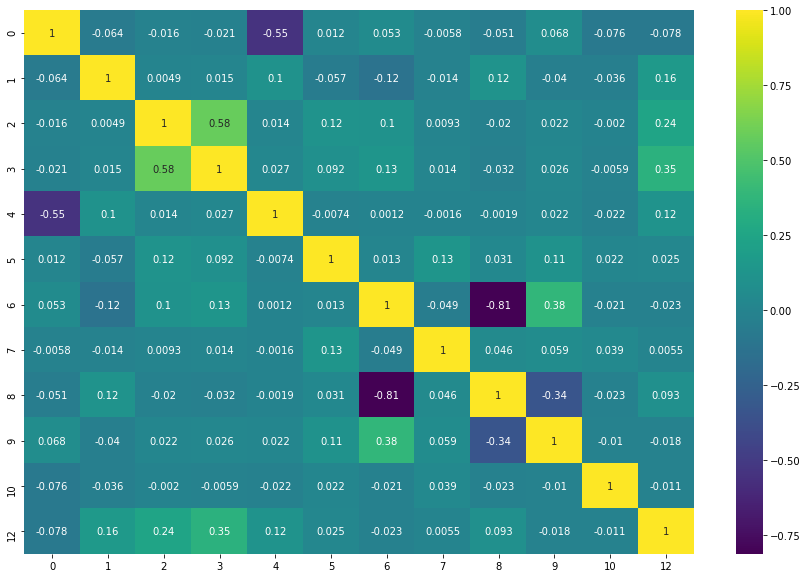

In [9]:
import seaborn as sns
new_df = new_df.drop([new_df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = new_df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [10]:
new_df = new_df.to_numpy() 

In [11]:
# new
inp_num = 11
x = new_df[:, 0:inp_num]
y = new_df[:, inp_num]
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

In [12]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 2000

start = time.time()  # 시작 시간 저장
with tf.device("/cpu:0"):
    model = Sequential()
    model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch)
    model.save('Original_Existing_model_mlp_2000.h5')
    print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/2000
53321/53321 [==============================] - 30s 556us/step - loss: 0.0941 - acc: 0.8896 - val_loss: 0.0886 - val_acc: 0.8899
Epoch 2/2000
53321/53321 [==============================] - 29s 540us/step - loss: 0.0857 - acc: 0.8899 - val_loss: 0.0837 - val_acc: 0.8899
Epoch 3/2000
53321/53321 [==============================] - 29s 535us/step - loss: 0.0828 - acc: 0.8899 - val_loss: 0.0820 - val_acc: 0.8897
Epoch 4/2000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8899 - val_loss: 0.0810 - val_acc: 0.8902
Epoch 5/2000
53321/53321 [==============================] - 34s 641us/step - loss: 0.0808 - acc: 0.8901 - val_loss: 0.0804 - val_acc: 0.8904
Epoch 6/2000
53321/53321 [==============================] - 33s 614us/step - loss: 0.0803 - acc: 0.8902 - val_loss: 0.0801 - val_acc: 0.8905
Epoch 7/2000
53321/53321 [==============================] - 33s 619us/step - loss: 0.0801 - acc: 0.8903 - val_loss: 0.0799 - val_acc: 0.8906
Epoch 8/2000


53321/53321 [==============================] - 31s 578us/step - loss: 0.0789 - acc: 0.8915 - val_loss: 0.0788 - val_acc: 0.8917
Epoch 59/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0789 - acc: 0.8915 - val_loss: 0.0788 - val_acc: 0.8916
Epoch 60/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0789 - acc: 0.8915 - val_loss: 0.0788 - val_acc: 0.8919
Epoch 61/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0789 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8917
Epoch 62/2000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0789 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8919
Epoch 63/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0789 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8918
Epoch 64/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0789 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8919
Epoch 65/2000
53321/

53321/53321 [==============================] - 31s 579us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 116/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8919
Epoch 117/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 118/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 119/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0783 - val_acc: 0.8919
Epoch 120/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 121/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 122/2000

53321/53321 [==============================] - 31s 579us/step - loss: 0.0782 - acc: 0.8919 - val_loss: 0.0781 - val_acc: 0.8922
Epoch 173/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0782 - acc: 0.8919 - val_loss: 0.0781 - val_acc: 0.8922
Epoch 174/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0782 - acc: 0.8919 - val_loss: 0.0781 - val_acc: 0.8922
Epoch 175/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0782 - acc: 0.8919 - val_loss: 0.0781 - val_acc: 0.8921
Epoch 176/2000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0782 - acc: 0.8919 - val_loss: 0.0781 - val_acc: 0.8921
Epoch 177/2000
53321/53321 [==============================] - 32s 604us/step - loss: 0.0782 - acc: 0.8919 - val_loss: 0.0781 - val_acc: 0.8922
Epoch 178/2000
53321/53321 [==============================] - 31s 572us/step - loss: 0.0782 - acc: 0.8919 - val_loss: 0.0781 - val_acc: 0.8922
Epoch 179/2000

53321/53321 [==============================] - 31s 579us/step - loss: 0.0780 - acc: 0.8921 - val_loss: 0.0779 - val_acc: 0.8923
Epoch 230/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0780 - acc: 0.8921 - val_loss: 0.0779 - val_acc: 0.8922
Epoch 231/2000
53321/53321 [==============================] - 30s 572us/step - loss: 0.0780 - acc: 0.8921 - val_loss: 0.0779 - val_acc: 0.8923
Epoch 232/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0780 - acc: 0.8920 - val_loss: 0.0779 - val_acc: 0.8923
Epoch 233/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0780 - acc: 0.8921 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 234/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0780 - acc: 0.8921 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 235/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0780 - acc: 0.8921 - val_loss: 0.0779 - val_acc: 0.8922
Epoch 236/2000

53321/53321 [==============================] - 31s 576us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 287/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 288/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 289/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 290/2000
53321/53321 [==============================] - 30s 571us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 291/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 292/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 293/2000

53321/53321 [==============================] - 31s 580us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8926
Epoch 344/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8926
Epoch 345/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 346/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8926
Epoch 347/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 348/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0778 - val_acc: 0.8926
Epoch 349/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 350/2000

53321/53321 [==============================] - 31s 578us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.89269 - a
Epoch 401/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 402/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 403/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 404/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 405/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 406/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 407

53321/53321 [==============================] - 31s 576us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 458/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0778 - val_acc: 0.8926
Epoch 459/2000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 460/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0778 - val_acc: 0.8926- ETA: 0s - loss: 0.0778 - acc: 0.89
Epoch 461/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 462/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8927
Epoch 463/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0

53321/53321 [==============================] - 31s 574us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 515/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 516/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 517/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 518/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 519/2000
53321/53321 [==============================] - 30s 572us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 520/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 521/2000

53321/53321 [==============================] - 31s 578us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 572/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 573/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 574/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 575/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 576/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 577/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 578/2000

53321/53321 [==============================] - 31s 575us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 629/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 630/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 631/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 632/2000
53321/53321 [==============================] - 31s 572us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 633/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 634/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 635/2000

53321/53321 [==============================] - 31s 578us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 686/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 687/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 688/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 689/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 690/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 691/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 692/2000

53321/53321 [==============================] - 31s 576us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 743/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 744/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 745/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 746/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 747/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8928
Epoch 748/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 749/2000

53321/53321 [==============================] - 31s 575us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 800/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 801/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 802/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 803/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 804/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 805/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 806/2000

53321/53321 [==============================] - 31s 579us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 857/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 858/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 859/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 860/2000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 861/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 862/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 863/2000

53321/53321 [==============================] - 31s 575us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 914/2000
53321/53321 [==============================] - 31s 572us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 915/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 916/2000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 917/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 918/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 919/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 920/2000

53321/53321 [==============================] - 31s 576us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 971/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 972/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 973/2000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 974/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 975/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 976/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 977/2000

53321/53321 [==============================] - 31s 576us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1028/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1029/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1030/2000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1031/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1032/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1033/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 10

53321/53321 [==============================] - 32s 599us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1085/2000
53321/53321 [==============================] - 32s 606us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1086/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1087/2000
53321/53321 [==============================] - 33s 620us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1088/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1089/2000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 1090/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 10

53321/53321 [==============================] - 31s 576us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1142/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1143/2000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1144/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1145/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1146/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1147/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 11

Epoch 1198/2000
53321/53321 [==============================] - 33s 613us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1199/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1200/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1201/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1202/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1203/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1204/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc:

Epoch 1255/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1256/2000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1257/2000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1258/2000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1259/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1260/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1261/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc:

Epoch 1312/2000
53321/53321 [==============================] - 34s 636us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1313/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1314/2000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1315/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1316/2000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1317/2000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1318/2000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc:

53321/53321 [==============================] - 37s 687us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1369/2000
53321/53321 [==============================] - 34s 632us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1370/2000
53321/53321 [==============================] - 33s 619us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1371/2000
53321/53321 [==============================] - 33s 615us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1372/2000
53321/53321 [==============================] - 33s 620us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1373/2000
53321/53321 [==============================] - 33s 614us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1374/2000
53321/53321 [==============================] - 33s 623us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 13

53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1426/2000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1427/2000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1428/2000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1429/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1430/2000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1431/2000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 14

53321/53321 [==============================] - 32s 602us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1483/2000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1484/2000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1485/2000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1486/2000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1487/2000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1488/2000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 14

53321/53321 [==============================] - 33s 620us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1540/2000
53321/53321 [==============================] - 34s 640us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1541/2000
53321/53321 [==============================] - 33s 621us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1542/2000
53321/53321 [==============================] - 35s 651us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1543/2000
53321/53321 [==============================] - 34s 630us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1544/2000
53321/53321 [==============================] - 34s 638us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1545/2000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 15

53321/53321 [==============================] - 32s 602us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1597/2000
53321/53321 [==============================] - 32s 609us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1598/2000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1599/2000
53321/53321 [==============================] - 32s 603us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1600/2000
53321/53321 [==============================] - 32s 603us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1601/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1602/2000
53321/53321 [==============================] - 33s 622us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 16

53321/53321 [==============================] - 32s 604us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1654/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1655/2000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1656/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 1657/2000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1658/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1659/2000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 16

53321/53321 [==============================] - 33s 615us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1710/2000
53321/53321 [==============================] - 33s 614us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1711/2000
53321/53321 [==============================] - 33s 616us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1712/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1713/2000
53321/53321 [==============================] - 33s 618us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 1714/2000
53321/53321 [==============================] - 33s 617us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1715/2000
53321/53321 [==============================] - 43s 798us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 17

53321/53321 [==============================] - 32s 591us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1767/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1768/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1769/2000
53321/53321 [==============================] - 32s 602us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1770/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1771/2000
53321/53321 [==============================] - 32s 607us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1772/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 17

53321/53321 [==============================] - 31s 589us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1824/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1825/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1826/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1827/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1828/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 1829/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 18

53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1881/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1882/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1883/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1884/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1885/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1886/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 18

53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1938/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1939/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1940/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1941/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1942/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8929
Epoch 1943/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 19

53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1995/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1996/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1997/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1998/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1999/2000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2000/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
time : 6

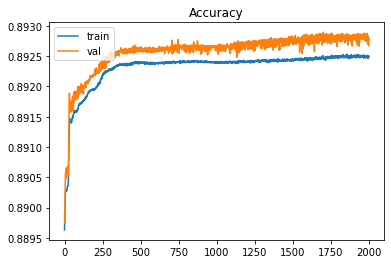

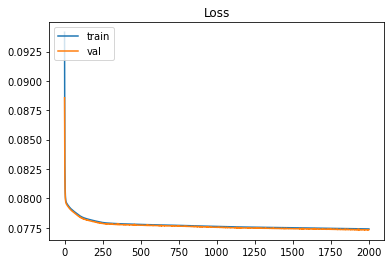

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [14]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 3000

start = time.time()  # 시작 시간 저장
with tf.device("/cpu:0"):
    model = Sequential()
    model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch)
    model.save('Original_Existing_model_mlp_3000.h5')
    print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0933 - acc: 0.8899 - val_loss: 0.0886 - val_acc: 0.8899
Epoch 2/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0858 - acc: 0.8899 - val_loss: 0.0839 - val_acc: 0.8899
Epoch 3/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0830 - acc: 0.8899 - val_loss: 0.0822 - val_acc: 0.8898
Epoch 4/3000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0817 - acc: 0.8900 - val_loss: 0.0811 - val_acc: 0.8902
Epoch 5/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0809 - acc: 0.8901 - val_loss: 0.0805 - val_acc: 0.8905
Epoch 6/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0804 - acc: 0.8902 - val_loss: 0.0801 - val_acc: 0.8906
Epoch 7/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0801 - acc: 0.8903 - val_loss: 0.0799 - val_acc: 0.8905
Epoch 8/3000


53321/53321 [==============================] - 32s 599us/step - loss: 0.0791 - acc: 0.8915 - val_loss: 0.0790 - val_acc: 0.8918
Epoch 59/3000
53321/53321 [==============================] - 32s 609us/step - loss: 0.0791 - acc: 0.8915 - val_loss: 0.0790 - val_acc: 0.8917
Epoch 60/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0791 - acc: 0.8915 - val_loss: 0.0790 - val_acc: 0.8918
Epoch 61/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0790 - acc: 0.8915 - val_loss: 0.0789 - val_acc: 0.8917
Epoch 62/3000
53321/53321 [==============================] - 32s 604us/step - loss: 0.0790 - acc: 0.8915 - val_loss: 0.0789 - val_acc: 0.8919
Epoch 63/3000
53321/53321 [==============================] - 32s 609us/step - loss: 0.0790 - acc: 0.8916 - val_loss: 0.0789 - val_acc: 0.8917
Epoch 64/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0790 - acc: 0.8916 - val_loss: 0.0789 - val_acc: 0.8918
Epoch 65/3000
53321/

53321/53321 [==============================] - 32s 600us/step - loss: 0.0785 - acc: 0.8917 - val_loss: 0.0784 - val_acc: 0.8919
Epoch 116/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0785 - acc: 0.8917 - val_loss: 0.0784 - val_acc: 0.8918
Epoch 117/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0785 - acc: 0.8917 - val_loss: 0.0784 - val_acc: 0.8920
Epoch 118/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0785 - acc: 0.8917 - val_loss: 0.0784 - val_acc: 0.8919
Epoch 119/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0785 - acc: 0.8917 - val_loss: 0.0784 - val_acc: 0.8918
Epoch 120/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0783 - val_acc: 0.8919
Epoch 121/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0783 - val_acc: 0.8919
Epoch 122/3000

53321/53321 [==============================] - 32s 591us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 173/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 174/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 175/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 176/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 177/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 178/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0781 - acc: 0.8921 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 179/3000

53321/53321 [==============================] - 32s 591us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 230/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 231/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 232/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 233/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 234/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 235/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 236/3000

53321/53321 [==============================] - 31s 585us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 287/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 288/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 289/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 290/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 291/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 292/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0779 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 293/3000

53321/53321 [==============================] - 31s 585us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 344/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 345/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 346/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 347/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 348/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 349/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 350/3000

53321/53321 [==============================] - 31s 584us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 401/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 402/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 403/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 404/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 405/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 406/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 407/3000

53321/53321 [==============================] - 31s 590us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 458/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8926
Epoch 459/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 460/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0778 - val_acc: 0.8926
Epoch 461/3000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 462/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 463/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 464/3000

Epoch 514/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 515/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 516/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 517/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 518/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 519/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 520/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0778 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926

Epoch 571/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 572/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 573/3000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 574/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 575/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 576/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 577/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926

53321/53321 [==============================] - 31s 588us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 629/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 630/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 631/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 632/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 633/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 634/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 635/3000

53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 686/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 687/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 688/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 689/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 690/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 691/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 692/3000

53321/53321 [==============================] - 31s 587us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 743/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 744/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 745/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 746/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 747/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 748/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 749/3000

53321/53321 [==============================] - 31s 584us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 800/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 801/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 802/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 803/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 804/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 805/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 806/3000

53321/53321 [==============================] - 32s 597us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 857/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 858/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 859/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 860/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 861/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 862/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 863/3000

53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 914/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 915/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 916/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 917/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 918/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 919/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 920/3000

53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 971/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 972/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8927
Epoch 973/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 974/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 975/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 976/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 977/3000

53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1028/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1029/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1030/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1031/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1032/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1033/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 10

53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1085/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1086/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1087/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1088/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1089/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1090/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 10

53321/53321 [==============================] - 32s 591us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1142/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1143/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1144/3000
53321/53321 [==============================] - 32s 604us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1145/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1146/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1147/3000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 11

53321/53321 [==============================] - 32s 598us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1199/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1200/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1201/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1202/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1203/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1204/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 12

53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1256/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1257/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1258/3000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1259/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1260/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1261/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 12

53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1313/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1314/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1315/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1316/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1317/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1318/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 13

53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1370/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1371/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1372/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1373/3000
53321/53321 [==============================] - 32s 608us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1374/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1375/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 13

Epoch 1426/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1427/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1428/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1429/3000
53321/53321 [==============================] - 35s 648us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1430/3000
53321/53321 [==============================] - 33s 619us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1431/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1432/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc:

53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1483/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1484/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1485/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1486/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1487/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1488/3000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 14

53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1540/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1541/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1542/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1543/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1544/3000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1545/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 15

53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1597/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1598/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1599/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1600/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1601/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1602/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 16

53321/53321 [==============================] - 31s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1654/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1655/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1656/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 1657/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1658/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1659/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 16

53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1711/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1712/3000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1713/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1714/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1715/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1716/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 17

53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1768/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1769/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1770/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1771/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1772/3000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1773/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 17

53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1825/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1826/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1827/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1828/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1829/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1830/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 18

Epoch 1881/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1882/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1883/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1884/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1885/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1886/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1887/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 1938/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1939/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1940/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1941/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1942/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1943/3000
53321/53321 [==============================] - 32s 603us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1944/3000
53321/53321 [==============================] - 37s 695us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 1995/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1996/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1997/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1998/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1999/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2000/3000
53321/53321 [==============================] - 32s 608us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2001/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 2052/3000
53321/53321 [==============================] - 32s 608us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8928
Epoch 2053/3000
53321/53321 [==============================] - 33s 622us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2054/3000
53321/53321 [==============================] - 33s 615us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2055/3000
53321/53321 [==============================] - 33s 626us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2056/3000
53321/53321 [==============================] - 35s 647us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2057/3000
53321/53321 [==============================] - 33s 620us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2058/3000
53321/53321 [==============================] - 35s 653us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

53321/53321 [==============================] - 32s 601us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2109/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2110/3000
53321/53321 [==============================] - 33s 611us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2111/3000
53321/53321 [==============================] - 34s 634us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2112/3000
53321/53321 [==============================] - 32s 602us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2113/3000
53321/53321 [==============================] - 34s 639us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2114/3000
53321/53321 [==============================] - 33s 613us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 21

53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2166/3000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2167/3000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2168/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2169/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2170/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2171/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 21

53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2223/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2224/3000
53321/53321 [==============================] - 33s 614us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2225/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2226/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2227/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2228/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 22

53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2279/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2280/3000
53321/53321 [==============================] - 33s 616us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2281/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2282/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2283/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2284/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 22

53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2336/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2337/3000
53321/53321 [==============================] - 32s 606us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2338/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2339/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2340/3000
53321/53321 [==============================] - 35s 657us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2341/3000
53321/53321 [==============================] - 36s 684us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 23

53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2393/3000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2394/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2395/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2396/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2397/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2398/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 23

53321/53321 [==============================] - 34s 635us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2449/3000
53321/53321 [==============================] - 34s 639us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2450/3000
53321/53321 [==============================] - 36s 673us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927: 2s - loss: 0
Epoch 2451/3000
53321/53321 [==============================] - 35s 648us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2452/3000
53321/53321 [==============================] - 37s 703us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2453/3000
53321/53321 [==============================] - 36s 666us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2454/3000
53321/53321 [==============================] - 34s 642us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0

Epoch 2505/3000
53321/53321 [==============================] - 36s 670us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2506/3000
53321/53321 [==============================] - 34s 638us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2507/3000
53321/53321 [==============================] - 34s 633us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2508/3000
53321/53321 [==============================] - 30s 564us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2509/3000
53321/53321 [==============================] - 29s 546us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2510/3000
53321/53321 [==============================] - 28s 533us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2511/3000
53321/53321 [==============================] - 29s 545us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 2562/3000
53321/53321 [==============================] - 29s 542us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2563/3000
53321/53321 [==============================] - 29s 540us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2564/3000
53321/53321 [==============================] - 28s 534us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2565/3000
53321/53321 [==============================] - 28s 519us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2566/3000
53321/53321 [==============================] - 30s 562us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2567/3000
53321/53321 [==============================] - 29s 535us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2568/3000
53321/53321 [==============================] - 28s 527us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 2619/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2620/3000
53321/53321 [==============================] - 30s 562us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2621/3000
53321/53321 [==============================] - 30s 559us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928 0s - loss: 0.0774 - acc: 0. - ETA: 0s - loss: 0.0774
Epoch 2622/3000
53321/53321 [==============================] - 29s 542us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2623/3000
53321/53321 [==============================] - 29s 547us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2624/3000
53321/53321 [==============================] - 29s 550us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2625/3000
53321/53321 [==============================] - 29s 549us/step - los

53321/53321 [==============================] - 29s 536us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2676/3000
53321/53321 [==============================] - 29s 549us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2677/3000
53321/53321 [==============================] - 28s 528us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2678/3000
53321/53321 [==============================] - 27s 507us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2679/3000
53321/53321 [==============================] - 27s 504us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2680/3000
53321/53321 [==============================] - 27s 501us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2681/3000
53321/53321 [==============================] - 27s 514us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 26

53321/53321 [==============================] - 24s 455us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2733/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2734/3000
53321/53321 [==============================] - 25s 465us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2735/3000
53321/53321 [==============================] - 24s 456us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2736/3000
53321/53321 [==============================] - 24s 455us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2737/3000
53321/53321 [==============================] - 24s 455us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2738/3000
53321/53321 [==============================] - 24s 457us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 27

Epoch 2789/3000
53321/53321 [==============================] - 24s 451us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2790/3000
53321/53321 [==============================] - 24s 452us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2791/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2792/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2793/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2794/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2795/3000
53321/53321 [==============================] - 24s 452us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 2846/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2847/3000
53321/53321 [==============================] - 24s 455us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2848/3000
53321/53321 [==============================] - 24s 456us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2849/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2850/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2851/3000
53321/53321 [==============================] - 25s 465us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2852/3000
53321/53321 [==============================] - 24s 456us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 2903/3000
53321/53321 [==============================] - 25s 463us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2904/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2905/3000
53321/53321 [==============================] - 24s 456us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2906/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2907/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2908/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2909/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

Epoch 2960/3000
53321/53321 [==============================] - 25s 460us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2961/3000
53321/53321 [==============================] - 24s 449us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2962/3000
53321/53321 [==============================] - 24s 450us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2963/3000
53321/53321 [==============================] - 24s 451us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2964/3000
53321/53321 [==============================] - 26s 481us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 2965/3000
53321/53321 [==============================] - 24s 451us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8929
Epoch 2966/3000
53321/53321 [==============================] - 25s 464us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc:

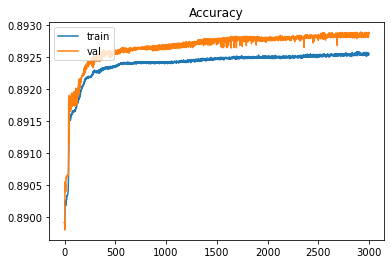

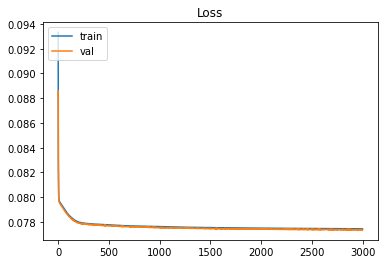

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()